# Step 1: Data Exploration

Import the dataset FinalRaw.csv as data

In [4]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("FinalRaw.csv")

View the data

In [3]:
print len(data)
data.head()

710201


,GoverningStateCode,DistributionChannelName,FirmCode,total_ann_prem,total_fee,CL_Limit,CP_Limit,BI_Limit,PD_Limit,MP_Limit,...,vehxdrv,year,Yearmonth,season,paymentmethodlong,assoc_grp,affin_grp,maxvehvalue,noncancelendmts,firstterm_survival
0,AZ,Direct,19,519.0,21.0,500.0,500.0,250/500,100.0,5000.0,...,32,2011,1,4,Direct Bill,GOOD SAM,AFFRV,86672,2,1
1,SC,Agency,28,824.0,0.0,500.0,500.0,25/50,25.0,NaN,...,11,2011,1,4,Direct Bill,PRIMARY AGENCY PLAN CODE,AGNCY,0,0,1
2,SC,Direct,18,2905.0,1.0,500.0,500.0,100/300,100.0,NaN,...,33,2011,1,4,Auto Pay - Checking/Savings,ALLY MORTGAGE,ALLY,0,3,1
3,AZ,Direct,20,363.0,15.0,500.0,NaN,100/300,50.0,NaN,...,32,2011,1,4,Direct Bill,LEGIONNAIRES,AFFAUxRLC,45000,4,1
4,AZ,Direct,19,587.0,15.0,500.0,250.0,250/500,100.0,10000.0,...,42,2011,1,4,Direct Bill,GOOD SAM,AFFRV,91279,1,1


Produce one new variable GRP_AFFIN_GRP using AFFIN_GRP by combining all categories other than "AFFRV", "AGNCY", and "BDMKT" to a new category “Others”.

In [4]:
data.groupby('affin_grp')['affin_grp'].agg({'Frequency':'count'})

,Frequency
affin_grp,
AFFAUxRLC,10251
AFFRV,87640
AGNCY,514571
ALLY,3278
BDMKT,59970
FF,15615
GMREL,11042
INTER,358
RLC,4905


In [5]:
data['grp_affin_grp'] = data['affin_grp'].fillna('Other')
clean_affin_grp = {'ALLY' : 'Other' , 'AFFAUxRLC' : 'Other' , 'GMREL' : 'Other' ,
                   'FF' : 'Other' , 'RLC' : 'Other' , 'INTER' : 'Other'}
data['grp_affin_grp'].replace(clean_affin_grp, inplace = True)
data.groupby('grp_affin_grp')['grp_affin_grp'].agg({'Frequency':'count'})

,Frequency
grp_affin_grp,
AFFRV,87640
AGNCY,514571
BDMKT,59970
Other,48020


Produce a vertical bar char using SGPLOT on this newly created variable.

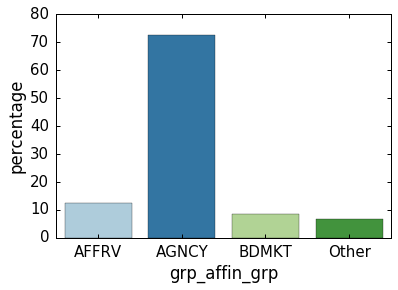

In [6]:
n_obs = float(len(data))
grp_affin_grp_pct = {'grp_affin_grp': ['AFFRV','AGNCY','BDMKT','Other'],
                     'percentage':[(len(data[data['grp_affin_grp'] == 'AFFRV']))/n_obs*100,
                                   (len(data[data['grp_affin_grp'] == 'AGNCY']))/n_obs*100,
                                   (len(data[data['grp_affin_grp'] == 'BDMKT']))/n_obs*100,
                                   (len(data[data['grp_affin_grp'] == 'Other']))/n_obs*100]}

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
with sns.color_palette("Paired"):
    plt = sns.barplot(x ='grp_affin_grp', y ='percentage', data = grp_affin_grp_pct)
    plt.set(xlabel = 'grp_affin_grp', ylabel = 'percentage')

Produce a histogram with kernel density line imposed using SGPLOT on the variable total_fee.

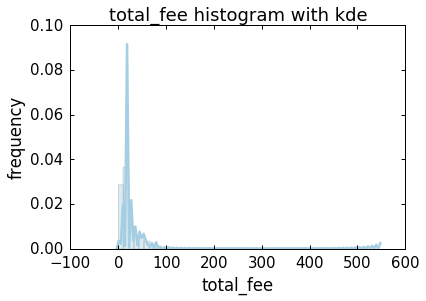

In [7]:
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
with sns.color_palette('Paired'):
    plt = sns.distplot(data['total_fee'], bins=50, kde=True)
    plt.set(xlabel = 'total_fee', ylabel='frequency', title = 'total_fee histogram with kde')

# Step 2: Categorical Variables Recoding

Fix affin_grp: Reduce Categories to four categories "AFFRV", "AGNCY", "BDMKT", and “OTHERS”. 

In [8]:
data['affin_grp']= data['grp_affin_grp'] 
data['affin_grp'].unique()

array(['AFFRV', 'AGNCY', 'Other', 'BDMKT'], dtype=object)

Remove GRP_AFFIN_GRP.

In [9]:
data = data.drop('grp_affin_grp', axis = 1)

Create Three Missing Value Indicators:
* MI_PIP_limit = "Missing Indicator: PIP_Limit"
* MI_CP_limit = "Missing Indicator: CP_Limit"
* MI_Others = "Missing Indicator: All Other Categorical Variables with Missing"

In [260]:
data['MI_PIP_limit'] = data['PIP_Limit'].fillna(1)
data.loc[data['MI_PIP_limit'] != 1] = 0

data['MI_CP_limit'] = data['CP_Limit'].fillna(1)
data.loc[data['MI_CP_limit'] != 1] = 0

In [261]:
catCols = ['BI_Limit', 'CreditActionCode', 'DistributionChannelName', 
           'GoverningStateCode', 'HomeownerInd', 'MarketingPlanCode',
          'PaymentMethodName', 'PaymentPlanDesc', 'PreferredMailDocumentsCode',
          'PriorCarrierTypeCode', 'ProductVersionName', 'StateGroup',
          'StateRegion', 'affin_grp', 'assoc_grp', 'paymentmethodlong',
          'premcat']

data['MI_Others'] = data[catCols].isnull().any(axis=1)
bool_map = {True : 1, False: 0}
data['MI_Others'].replace(bool_map, inplace = True)
data['MI_Others'].unique()

array([False, True], dtype=object)

**Mode Imputation** for Categorical Variables: BIGroupNum , HomeownerInd , PreferredMailDocumentsCode, and PriorCarrierTypeCode

In [262]:
data['BIGroupNum'].fillna(data['BIGroupNum'].mode(), inplace=True)
data['HomeownerInd'].fillna(data['HomeownerInd'].mode(), inplace=True)
data['PreferredMailDocumentsCode'].fillna(data['PreferredMailDocumentsCode'] \
                                          .mode(), inplace=True)
data['PriorCarrierTypeCode'].fillna(data['PriorCarrierTypeCode'].mode()
                                    , inplace=True) 

Drop variables: assoc_grp, MarketingPlanCode, GoverningStateCode

In [263]:
data = data.drop('assoc_grp', axis = 1)
data = data.drop('GoverningStateCode', axis = 1)
data = data.drop('MarketingPlanCode', axis = 1)

In [10]:
data['PaymentPlanDesc'].unique()

array(['20% Down, 4 Payments', 'Pay in Full', '16.7% Down, 5 Payments',
       '33.3% Down, 4 Payments', '20% Down, 5 Payments',
       '10% Down, 10 Payments', '12.5% Down, 10 Payments',
       '8.3% Down, 11 Payments', '25% Down, 4 Payments',
       '16.7% Down, 10 Payments', '25% Down, 3 Payments',
       '40% Down, 3 Payments', '50% down, 1 Payment',
       '25% Down, 5 Payments', '20% Down, 8 Payments',
       '50% Down, 1 Payments', '16% Down, 10 Payments',
       '20% Down, 6 Payments', '40% Down, 4 Payments',
       '20% down, 11 Payments', '50% Down, 2 Payments',
       '33% Down, 4 Payments', '33.4% Down, 4 Payments',
       '8.3% down, 11 Payments', '10% Down, 11 Payments',
       '8.33% Down, 11 Payments', '20% down, 10 Payments',
       '16.7% Down, 11 Payments', '20% Down, 10 Payments',
       '5% Down, 23 Payments', '20% Down, 11 Payments',
       '9% Down, 11 Payments', '33% Down, 3 Payments',
       '34% Down, 4 Payments', '15% Down, 9 Payments',
       '9.5% Down, 11 

Split PaymentPlanDesc into two numerical variables N_Payment, DownPayPct 

In [264]:
#if plan is missing, then dp = 100 and n = 0
#if plan is better budget then dp = 0 and n = 1
#if plan is pay in full then dp = 100 and n = 0
data['PaymentPlanDesc'].fillna('100% Down, 0 Payments')
pay_plan_map = {'Pay in Full' : '100% Down, 0 Payments', 
                'Better Budget': '0% Down, 1 Payments',
                0 : '100% Down, 0 Payments'}
data['PaymentPlanDesc'].replace(pay_plan_map, inplace = True)
data['DownPayPct'] = data['PaymentPlanDesc'].str.split(', ').str[0] \
.str.split(' ').str[0].str.split('%').str[0]
data['N_Payment'] = data['PaymentPlanDesc'].str.split(', ').str[1] \
.str.split(' ').str[0]

For **ProductVersionName**, we can see that we need to combine low frequency categories

In [265]:
pay_plan_map = {'NY Direct no tier' : 'NY RAD','NY non-RAD Agency': 'NY RAD',
                'RAD5LowCost' : 'RAD5' , 'NCAA' : 'NC non-RAD', 
                '4 Tier' : '2 Tier'}
data['ProductVersionName'].replace(pay_plan_map, inplace = True)

For **CreditActionCode**, take the first letter of the CreditActionCode

In [266]:
data['FL_CreditActionCode'] = data['CreditActionCode'].str.replace('R','S'). \
str.slice(0,1,1)
data['FL_CreditActionCode'].unique()

array([nan, 'Q', 'T', 'Z', 'W', 'S', 'V', 'L', 'P', 'I', 'E', 'K', 'M',
       'H', 'G', 'D', 'U', 'J', 'F', 'C', 'N', 'A', '?', 'B', 'Y'], dtype=object)

Obtain **logit transformation** of the following variables StateGroup, ProductVersionName, and FL_CreditActionCode.
* Combine categories with frequency < threshold together
* Obtain proportion of response variable for each level of the categorical variable
* Obtain proportion of target = "Yes" and select smoothing factor
* Compute smoothed logeit for each level of the categorical variable

Let's look at the distribution of StateGroup:

In [267]:
data.groupby('StateGroup')['StateGroup'].agg({'Frequency':'count'})

,Frequency
StateGroup,
0,695596
LargeAL,105
LargeAZ,3471
LargeCA,607
LargeFL,782
LargeGA,12
LargeIN,14
LargeLA,79
LargeMI,13


Combiine all categories with less than 25 observations together into a category called 'Other'

In [268]:
state_group_map = {'LargeGA' : 'Other' , 'LargeIN' : 'Other', 'LargeMI' : 'Other',
                'LargeOH' : 'Other'}
data['StateGroup'].replace(state_group_map, inplace = True)

We can check the counts again to see that they are more evenly distributed:

In [269]:
data.groupby('StateGroup')['StateGroup'].agg({'Frequency':'count'})

,Frequency
StateGroup,
0,695596
LargeAL,105
LargeAZ,3471
LargeCA,607
LargeFL,782
LargeLA,79
LargeNC,4591
LargeNY,171
LargeOR,53


Repeat the provess for ProductVersionName.

In [270]:
data.groupby('ProductVersionName')['ProductVersionName'].agg({'Frequency':'count'})

,Frequency
ProductVersionName,
0,695596
10 Tier,10
2 Tier,97
Agency non-RAD,29
CA RAD 2.0,156
CA no tier,71
CASummit,2
Imperial,14
NC RAD5,345


In [271]:
product_version_map = {'10 Tier' : 'Other', 'CASummit' : 'Other',
                       'Imperial' : 'Other', 'Rad2.1' : 'Other'}
data['ProductVersionName'].replace(product_version_map, inplace = True)

The FL_CreditActionCode is distributed evenly enough that we do not need to cluster the low frequency categories.

Let's view the proportion of the response variable, 'firstterm_survival', for each level of 'StateGroup'

In [272]:
StateGroupSmoothingDf = data.groupby(['StateGroup','firstterm_survival'], as_index = False)['StateGroup'] \
.agg({'Frequency':'count'}).pivot('StateGroup','firstterm_survival').fillna(0)['Frequency']
StateGroupSmoothingDf

firstterm_survival,0,1
StateGroup,,
0,695596.0,0.0
LargeAL,31.0,74.0
LargeAZ,488.0,2983.0
LargeCA,156.0,451.0
LargeFL,123.0,659.0
LargeLA,21.0,58.0
LargeNC,708.0,3883.0
LargeNY,29.0,142.0
LargeOR,13.0,40.0


Now let's calculate the smoothed logit for each category of StateGroup

In [273]:
StateGroupSmoothingDf['Frequency'] = StateGroupSmoothingDf[0] + StateGroupSmoothingDf[1]
StateGroupSmoothingDf['Churn_Frequency'] = StateGroupSmoothingDf[1]
StateGroupSmoothingDf['Churn_Rate'] = StateGroupSmoothingDf['Churn_Frequency']/StateGroupSmoothingDf['Frequency']
StateGroupLength = len(data['StateGroup'])
StateGroupYes = len(data['StateGroup'][data['firstterm_survival'] == 1])
StateGroupNo = len(data['StateGroup'][data['firstterm_survival'] == 0])
Population_Proportion_Yes = float(StateGroupYes)/float(StateGroupLength)
Population_Proportion_No = float(StateGroupNo)/float(StateGroupLength)
SmoothingFactor = 2
StateGroupSmoothingDf['Logit_StateGroup'] = np.log((StateGroupSmoothingDf[1] + Population_Proportion_Yes*SmoothingFactor)/
                                       (StateGroupSmoothingDf[0] + Population_Proportion_No*SmoothingFactor))
StateGroupSmoothingDf

firstterm_survival,0,1,Frequency,Churn_Frequency,Churn_Rate,Logit_StateGroup
StateGroup,,,,,,
0,695596.0,0.0,695596.0,0.0,0.000000,-16.841522
LargeAL,31.0,74.0,105.0,74.0,0.704762,0.809036
LargeAZ,488.0,2983.0,3471.0,2983.0,0.859407,1.806360
LargeCA,156.0,451.0,607.0,451.0,0.742998,1.049161
LargeFL,123.0,659.0,782.0,659.0,0.842711,1.662731
LargeLA,21.0,58.0,79.0,58.0,0.734177,0.926999
LargeNC,708.0,3883.0,4591.0,3883.0,0.845785,1.699155
LargeNY,29.0,142.0,171.0,142.0,0.830409,1.523167
LargeOR,13.0,40.0,53.0,40.0,0.754717,0.983924


Repeat logit smoothing for ProductVersionName and FL_CreditActionCode

In [274]:
ProductSmoothingDf = data.groupby(['ProductVersionName','firstterm_survival'], as_index = False)['ProductVersionName'] \
.agg({'Frequency':'count'}).pivot('ProductVersionName','firstterm_survival').fillna(0)['Frequency']
ProductSmoothingDf['Frequency'] = ProductSmoothingDf[0] + ProductSmoothingDf[1]
ProductSmoothingDf['Churn_Frequency'] = ProductSmoothingDf[1]
ProductSmoothingDf['Churn_Rate'] = ProductSmoothingDf['Churn_Frequency']/ProductSmoothingDf['Frequency']
ProductSmoothingDf

firstterm_survival,0,1,Frequency,Churn_Frequency,Churn_Rate
ProductVersionName,,,,,
0,695596.0,0.0,695596.0,0.0,0.000000
2 Tier,24.0,73.0,97.0,73.0,0.752577
Agency non-RAD,7.0,22.0,29.0,22.0,0.758621
CA RAD 2.0,53.0,103.0,156.0,103.0,0.660256
CA no tier,17.0,54.0,71.0,54.0,0.760563
NC RAD5,106.0,239.0,345.0,239.0,0.692754
NC non-RAD,600.0,3644.0,4244.0,3644.0,0.858624
NY RAD 3.5,29.0,142.0,171.0,142.0,0.830409
Other,8.0,18.0,26.0,18.0,0.692308


In [275]:
ProductLength = len(data['ProductVersionName'])
ProductYes = len(data['ProductVersionName'][data['firstterm_survival'] == 1])
ProductNo = len(data['ProductVersionName'][data['firstterm_survival'] == 0])
Population_Proportion_Yes = float(ProductYes)/float(ProductLength)
Population_Proportion_No = float(ProductNo)/float(ProductLength)
SmoothingFactor = 2

ProductSmoothingDf['Logit_ProductVersionName'] = np.log((ProductSmoothingDf[1] + Population_Proportion_Yes*SmoothingFactor)/
                                     (ProductSmoothingDf[0] + Population_Proportion_No*SmoothingFactor))
ProductSmoothingDf

firstterm_survival,0,1,Frequency,Churn_Frequency,Churn_Rate,Logit_ProductVersionName
ProductVersionName,,,,,,
0,695596.0,0.0,695596.0,0.0,0.000000,-16.841522
2 Tier,24.0,73.0,97.0,73.0,0.752577,1.034124
Agency non-RAD,7.0,22.0,29.0,22.0,0.758621,0.899107
CA RAD 2.0,53.0,103.0,156.0,103.0,0.660256,0.628337
CA no tier,17.0,54.0,71.0,54.0,0.760563,1.046947
NC RAD5,106.0,239.0,345.0,239.0,0.692754,0.794786
NC non-RAD,600.0,3644.0,4244.0,3644.0,0.858624,1.800645
NY RAD 3.5,29.0,142.0,171.0,142.0,0.830409,1.523167
Other,8.0,18.0,26.0,18.0,0.692308,0.593039


In [276]:
CreditActionSmoothingDf = data.groupby(['FL_CreditActionCode','firstterm_survival'], as_index = False)['FL_CreditActionCode'] \
.agg({'Frequency':'count'}).pivot('FL_CreditActionCode','firstterm_survival').fillna(0)['Frequency']
CreditActionSmoothingDf['Frequency'] = CreditActionSmoothingDf[0] + CreditActionSmoothingDf[1]
CreditActionSmoothingDf['Churn_Frequency'] = CreditActionSmoothingDf[1]
CreditActionSmoothingDf['Churn_Rate'] = CreditActionSmoothingDf['Churn_Frequency']/CreditActionSmoothingDf['Frequency']
CreditActionSmoothingDf

firstterm_survival,0,1,Frequency,Churn_Frequency,Churn_Rate
FL_CreditActionCode,,,,,
?,119,354,473,354,0.748414
A,6,22,28,22,0.785714
B,23,60,83,60,0.722892
C,17,75,92,75,0.815217
D,23,112,135,112,0.829630
E,31,188,219,188,0.858447
F,85,335,420,335,0.797619
G,68,274,342,274,0.801170
H,76,327,403,327,0.811414


In [277]:
CreditActionLength = len(data['FL_CreditActionCode'])
CreditActionYes = len(data['FL_CreditActionCode'][data['firstterm_survival'] == 1])
CreditActionNo = len(data['FL_CreditActionCode'][data['firstterm_survival'] == 0])
Population_Proportion_Yes = float(CreditActionYes)/float(CreditActionLength)
Population_Proportion_No = float(CreditActionNo)/float(CreditActionLength)
SmoothingFactor = 2
CreditActionSmoothingDf['Logit_FL_CreditActionCode'] = np.log((CreditActionSmoothingDf[1] + Population_Proportion_Yes*SmoothingFactor)/
                                     (CreditActionSmoothingDf[0] + Population_Proportion_No*SmoothingFactor))
CreditActionSmoothingDf

firstterm_survival,0,1,Frequency,Churn_Frequency,Churn_Rate,Logit_FL_CreditActionCode
FL_CreditActionCode,,,,,,
?,119,354,473,354,0.748414,1.073881
A,6,22,28,22,0.785714,1.017360
B,23,60,83,60,0.722892,0.877382
C,17,75,92,75,0.815217,1.375276
D,23,112,135,112,0.829630,1.501275
E,31,188,219,188,0.858447,1.741137
F,85,335,420,335,0.797619,1.348711
G,68,274,342,274,0.801170,1.365238
H,76,327,403,327,0.811414,1.433787


Merge dataframes to assign smoothed logit to original dataset

In [278]:
data = data.join(StateGroupSmoothingDf['Logit_StateGroup'], 
                 on='StateGroup', how='inner')
data = data.join(ProductSmoothingDf['Logit_ProductVersionName'], 
                 on='ProductVersionName', how='inner')
data = data.join(CreditActionSmoothingDf['Logit_FL_CreditActionCode'], 
                 on='FL_CreditActionCode', how='inner')

Create a Cardinality Table for all categorical variables at this stage.

In [282]:
catCols = ['affin_grp', 'AIRB_disc', 'BIGroupNum', 'DistributionChannelName',
           'firstterm_survival', 'FL_CreditActionCode', 'HomeOwner_disc',
           'HomeownerInd', 'lonly', 'max22', 'max30', 'MI_CP_limit', 'MI_PIP_limit', 
           'move', 'Multicar_disc', 'paymentmethodlong', 'PaymentMethodName',
           'PIF_disc', 'pointed', 'PreferredMailDocumentsCode', 'premcat', 
           'PriorCarrierTypeCode', 'ProductVersionName', 'season', 'StateGroup', 
           'StateRegion', 'TermInMonthsNum', 'uwtiergroup', 'year', 'Yearmonth']
for col in catCols:
    print data[col].value_counts()

AGNCY    8088
BDMKT    2901
AFFRV    2183
Other    1433
Name: affin_grp, dtype: int64
0.0    12630
1.0     1389
Name: AIRB_disc, dtype: int64
1.0    9991
0.0    4614
Name: BIGroupNum, dtype: int64
Agency      11182
Direct       2797
Internet      626
Name: DistributionChannelName, dtype: int64
1    11982
0     2623
Name: firstterm_survival, dtype: int64
Z    1534
V    1221
U    1206
W    1179
S    1064
Q    1028
P     899
M     747
L     679
N     599
T     593
K     583
J     512
?     473
I     448
F     420
H     403
G     342
E     219
D     135
Y     118
C      92
B      83
A      28
Name: FL_CreditActionCode, dtype: int64
0    13309
1     1296
Name: HomeOwner_disc, dtype: int64
N    7511
Y    7094
Name: HomeownerInd, dtype: int64
0    10540
1     4065
Name: lonly, dtype: int64
0    12519
1     2086
Name: max22, dtype: int64
0    12448
1     2157
Name: max30, dtype: int64
1.0    14605
Name: MI_CP_limit, dtype: int64
1.0    14605
Name: MI_PIP_limit, dtype: int64
0    13804
1      8

# Step 3: Numerical Variables Preparation

Create missing value indicator for variable MP_LIMIT

In [283]:
data['MI_MP_Limit'] = data['MP_Limit'].fillna(1)
data.loc[data['MI_MP_Limit'] != 1] = 0

Use Median imputation on the following variables: CL_Limit, PD_Limit, MP_LIMIT, CREDITSCORENUM, INSURANCEEXPERIENCEDAYSNUM, PRECREDITTIERNUM, PRIORSWITCHESCOUNT, RATEMANUALNUM, and UWTIERNUM

In [284]:
data['CL_Limit'].fillna(data['CL_Limit'].median(), inplace=True)
data['PD_Limit'].fillna(data['PD_Limit'].median(), inplace=True)
data['MP_Limit'].fillna(data['MP_Limit'].median(), inplace=True)
data['CreditScoreNum'].fillna(data['CreditScoreNum'].median(), inplace=True)
data['InsuranceExperienceDaysNum'].fillna(data['InsuranceExperienceDaysNum'].median(), inplace=True)
data['PreCreditTierNum'].fillna(data['PreCreditTierNum'].median(), inplace=True)
data['PriorSwitchesCount'].fillna(data['PriorSwitchesCount'].median(), inplace=True)
data['RateManualNum'].fillna(data['RateManualNum'].median(), inplace=True)
data['uwtiergroup'].fillna(data['uwtiergroup'].median(), inplace=True)

Drop N_PAYMENT due to high correlation with PAYINSTALLMENTSNUM 

In [285]:
data = data.drop('N_Payment', axis=1)

Restrict the variable PNIAGE in the interval [16, 100]

In [286]:
data = data[data['PNIAge'].between(16,100, inclusive = True)]

Split the variable VEHXDRV to two variables N_Vehicles and N_Drivers.  The first digit to represent the number of vehicle and the second digit to represent the number of drivers.

In [287]:
data['N_Vehicles'] = data['vehxdrv'].astype(str).str.slice(0,1,1)
data['N_Drivers'] = data['vehxdrv'].astype(str).str.slice(1,2,1)

Perform rank transformation on the following variables RATEMANUALNUM N_MOD_BI_LIMIT FIRMCODE AGEGE75_LT30_LT21_POINTED PD_LIMIT MP_LIMIT MAXVEHVALUE PIP_LIMIT NEXTPREMCH

In [288]:
data['Rank_RateManualNum'] = data['RateManualNum'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_BI_Limit'] = data['BI_Limit'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_FirmCode'] = data['FirmCode'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_agege75_lt30_lt21_pointed'] = data['agege75_lt30_lt21_pointed'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_PD_Limit'] = data['PD_Limit'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_MP_Limit'] = data['MP_Limit'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_maxvehvalue'] = data['maxvehvalue'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_PIP_Limit'] = data['PIP_Limit'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_nextpremch'] = data['nextpremch'].rank(axis = 0, method='average', na_option='bottom', ascending=True)

Perform log transformation on the following variables: UWTIERNUM NONCANCELENDMTS INCURRED_LOSS. 

In [291]:
data['Log_uwtiernum'] = np.log(data['uwtiergroup'])
data['Log_noncancelendmts'] = np.log(data['noncancelendmts'])
data['Log_incurred_loss'] = np.log(data['incurred_loss'])

Perform rank transformation of the following three variables: DAYSLAPSENUM LOGIT_PRODUCTVERSIONNAME LASTENDMT

In [293]:
data['Rank_DaysLapseNum'] = data['DaysLapseNum'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_Logit_ProductVersionName'] = data['Logit_ProductVersionName'].rank(axis = 0, method='average', na_option='bottom', ascending=True)
data['Rank_lastendmt'] = data['lastendmt'].rank(axis = 0, method='average', na_option='bottom', ascending=True)

Perform square transformation of the following variables: LOGIT_FL_CREDITACTIONCODE and LOGIT_STATEGROUP

In [294]:
data['Square_Logit_FL_CreditActionCode']= data['Logit_FL_CreditActionCode']**2
data['Square_Logit_StateGroup']= data['Logit_StateGroup']**2

Perform power transformation of the following variables: 
* TOTAL_FEE: Power 0.5 
* TOTAL_ANN_PREM: Power 0.3125 
* CL_LIMIT: Power 0.25 
* NPCHCAT: Power 0.125 
* INSURANCEEXPERIENCEDAYSNUM: Power 0.375 
* CP_LIMIT: Power 0.4325

In [296]:
data['Power_total_fee']= data['total_fee']**(.5)
data['Power_total_ann_prem']= data['total_ann_prem']**(.3125)
data['Power_CL_Limit']= data['CL_Limit']**(.25)
data['Power_npchcat']= data['npchcat']**(.125)
data['Power_InsuranceExperienceDaysNum']= data['InsuranceExperienceDaysNum']**(.375)
data['Power_CP_Limit']= data['CP_Limit']**(.4325)

In [297]:
data

,DistributionChannelName,FirmCode,total_ann_prem,total_fee,CL_Limit,CP_Limit,BI_Limit,PD_Limit,MP_Limit,PIP_Limit,...,Rank_Logit_ProductVersionName,Rank_lastendmt,Square_Logit_FL_CreditActionCode,Square_Logit_StateGroup,Power_total_fee,Power_total_ann_prem,Power_CL_Limit,Power_npchcat,Power_InsuranceExperienceDaysNum,Power_CP_Limit
3,Direct,20,363.000000,15.00,500.0,NaN,100/300,50.0,0.0,NaN,...,380.5,1053.5,2.74574,3.262935,3.872983,6.309150,4.728708,0.000000,0.000000,NaN
83042,Agency,19,610.000000,19.50,500.0,NaN,50/100,50.0,0.0,NaN,...,380.5,217.5,2.74574,2.059213,4.415880,7.420199,4.728708,1.333521,16.829350,NaN
103189,Agency,19,1002.000000,41.00,500.0,NaN,30/60,25.0,0.0,NaN,...,380.5,957.0,2.74574,2.059213,6.403124,8.665052,4.728708,1.454215,21.386438,NaN
164650,Agency,19,883.000000,29.00,500.0,NaN,100/300,100.0,0.0,NaN,...,380.5,217.5,2.74574,2.059213,5.385165,8.329381,4.728708,0.000000,23.844205,NaN
256768,Agency,19,716.000000,21.50,500.0,NaN,100/300,100.0,0.0,NaN,...,380.5,217.5,2.74574,2.059213,4.636809,7.801180,4.728708,0.000000,22.867664,NaN
391990,Internet,18,512.000000,31.00,500.0,NaN,100/300,100.0,0.0,NaN,...,380.5,1343.0,2.74574,2.059213,5.567764,7.025009,4.728708,NaN,22.023666,NaN
460760,Internet,18,309.000000,31.00,500.0,NaN,300,50.0,0.0,NaN,...,380.5,571.5,2.74574,2.059213,5.567764,5.999458,4.728708,1.333521,23.296521,NaN
526070,Direct,18,760.000000,26.00,500.0,NaN,100/300,100.0,0.0,NaN,...,380.5,1053.5,2.74574,2.059213,5.099020,7.947934,4.728708,1.668280,20.534574,NaN
541345,Direct,18,1635.000000,25.00,1000.0,NaN,500/500,500.0,0.0,NaN,...,380.5,217.5,2.74574,2.059213,5.000000,10.097743,5.623413,1.333521,16.713322,NaN
557770,Internet,18,275.000000,95.62,1000.0,NaN,100/300,100.0,0.0,NaN,...,380.5,806.0,2.74574,2.059213,9.778548,5.784842,5.623413,1.333521,26.741773,NaN
